In [5]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [6]:
try:
    df_all = pd.read_csv('rugby.csv')
except:
    df_all = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)

In [7]:
df_all.describe()

home_score  away_score         year
count   60.000000   60.000000    60.000000
mean    23.500000   19.983333  2015.500000
std     14.019962   12.911028     1.127469
min      0.000000    0.000000  2014.000000
25%     16.000000   10.000000  2014.750000
50%     20.500000   18.000000  2015.500000
75%     27.250000   23.250000  2016.250000
max     67.000000   63.000000  2017.000000

In [9]:
df_all.tail()

home_team away_team  home_score  away_score  year
55     Italy    France          18          40  2017
56   England  Scotland          61          21  2017
57  Scotland     Italy          29           0  2017
58    France     Wales          20          18  2017
59   Ireland   England          13           9  2017

In [10]:
df = df_all[['home_team', 'away_team', 'home_score', 'away_score']]

In [11]:

teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

In [12]:
with pm.Model() as model:
    # global model parameters
    # home = pm.Flat('home')
    # home = pm.InverseGamma('home',alpha=1, beta=1)
    # home = pm.HalfNormal('home', sigma=100)
    home = pm.DiscreteUniform('home',lower=0,upper=10)
    # home = pm.Exponential('home',1)
    # home = pm.Gamma('home',1.5,10e-4)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    # intercept = pm.Flat('intercept')
    # intercept = pm.InverseGamma('intercept',alpha=1, beta=1)
    # intercept = pm.HalfNormal('intercept', sigma=100)
    intercept = pm.DiscreteUniform('intercept',lower=0,upper=10)
    # intercept = pm.Exponential('intercept',1)
    # intercept = pm.Gamma('intercept',1.5,10e-4)

    # team-specific model parameters
    # atts_star = pm.HalfNormal("atts_star", sigma=sd_att, shape=num_teams)
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)
    # defs_star = pm.HalfNormal("defs_star", sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

In [13]:
with model:
    trace = pm.sample(1000)
    prior = pm.sample_prior_predictive(samples=20)
    posterior = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [intercept]
>>Metropolis: [home]
>NUTS: [defs_star, atts_star, sd_def, sd_att]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8842350563150368, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
teams

team  i
0     Wales  0
1    France  1
2   Ireland  2
3  Scotland  3
4     Italy  4
5   England  5

In [27]:
import arviz as az
import panel as pn

with model:
    pm_data = az.from_pymc3(
            trace=trace,
            prior=prior,
            posterior_predictive=posterior,
            coords={'Teams':teams},
            dims=teams
    )

In [30]:
pm_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [14]:
def convert_models(models=[]):
    model_data = []
    for m in models:
        with m:
            data = az.from_pymc3(
                        trace=trace,
                        prior=prior,
                        posterior_predictive=posterior,
                    )
            model_data.append(data)
    return model_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94ce387a10>,
      dtype=object)

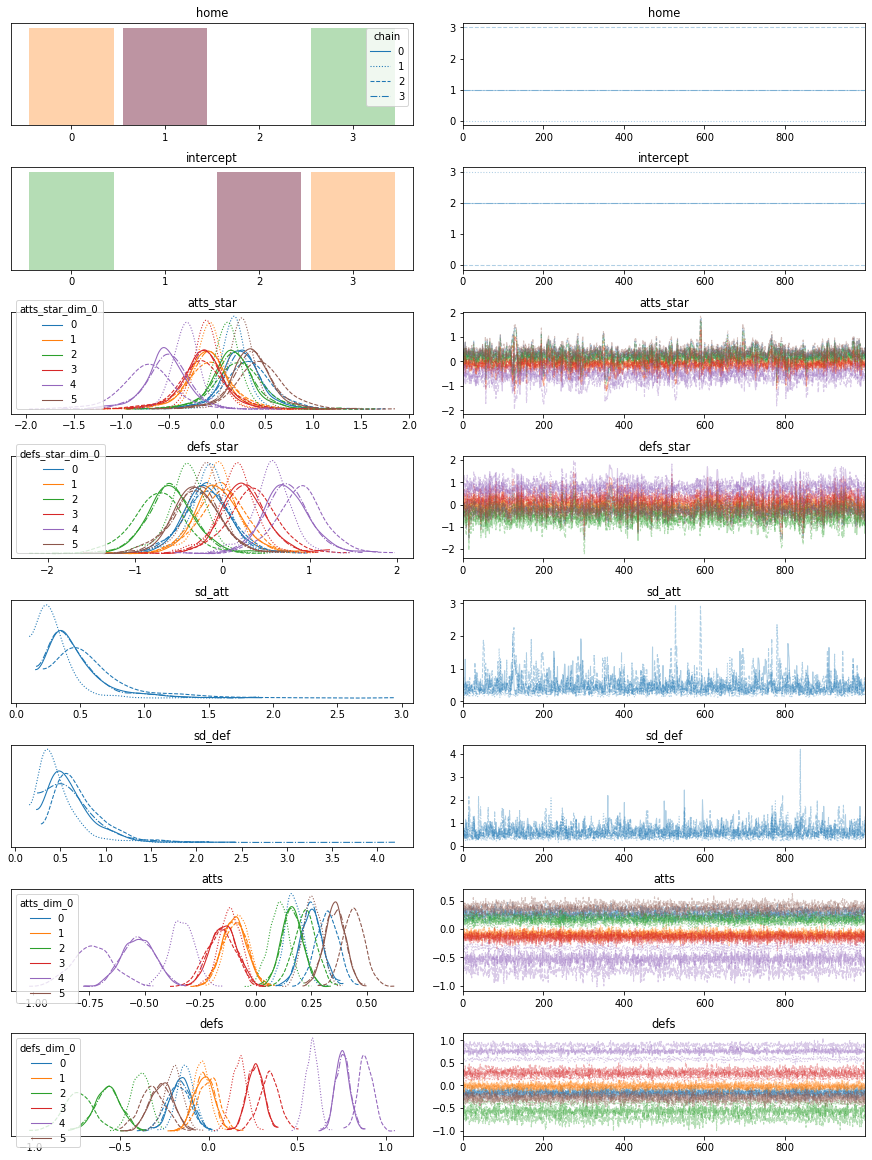

In [28]:
pm.traceplot(trace, legend=True)

In [47]:
        from bokeh.palettes import Dark2_5 as palette
        import itertools

        colors = itertools.cycle(palette) 
        kw = dict(outline_line_color=colors)
        axes = az.plot_trace(
            trace, 
            var_names='atts_star', 
            backend='bokeh',
            legend=True,
            compact=True,
            combined=True,
            show=False,
            )
        for a in axes[0]:
            t = a.title.text
            a.title.text = t+'hey'
        az.plots.backends.show_layout(axes)

In [50]:
import bokeh as Bokeh
import bokeh.plotting as bkp
from bokeh.models import Div
from bokeh.layouts import column, row
from bokeh.io import curdoc

def prior_density_plot(variable,data=models, plottype='Seperate Plots'):
    """
    Method for producing the prior kde plot using arviz plot_density. This is done 2 ways: either will produce all     the plots onto one graph or will produe them seperately

    The parameters are the data, plottype, either "Seperate Plots" or "Same Plots" 

    Also takes the variable to view which will be chosen by the dropdown in the program. Probably shouldnt be          hardcoded with a default as this will change with each model.  *** Will change later ***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key, value in data.items():
            kwg = dict(title=key)
            curdoc().theme = 'dark_minimal'
            plot = az.plot_density(
                value,
                group='prior', 
                var_names=variable,
                outline=False, 
                backend='bokeh',
                shade=.5, 
                show=False,
                backend_kwargs=kwg
                )
            """ ** Can't get the title to change with kwargs so workaround with html div ** """
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='prior', 
            var_names=variable,
            outline=False,  
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle'
            )
        col = column(plot[0].tolist())
    return col

In [51]:
import param

inputs_1 = list(pm_data.prior.data_vars)
inputs_2 = ['Same Plot', 'Seperate Plots']

    
class PriorDashboard(param.Parameterized):
    variable = param.Selector(inputs_1, default=inputs_1[0])
    plot_type = param.Selector(inputs_2, default=inputs_2[0])
    
    @param.depends('variable', 'plot_type')
    def plot(self):
        return prior_density_plot(variable=self.variable, data=models, plottype=self.plot_type)
    
    def panel(self):
        return pn.Row(self.param, self.plot)

In [52]:
pn.serve(dashboard.panel().servable())

Launching server at http://localhost:63124


In [15]:
m = [model]
data_m = convert_models(m)
models = {
  "prior_1": data_m[0],
}

In [16]:
import bokeh as Bokeh
import bokeh.plotting as bkp
from bokeh.models import Div
from bokeh.layouts import column, row
from bokeh.io import curdoc

def prior_density_plot(variable,data=models, plottype='Seperate Plots'):
    """
    Method for producing the prior kde plot using arviz plot_density. This is done 2 ways: either will produce all     the plots onto one graph or will produe them seperately

    The parameters are the data, plottype, either "Seperate Plots" or "Same Plots" 

    Also takes the variable to view which will be chosen by the dropdown in the program. Probably shouldnt be          hardcoded with a default as this will change with each model.  *** Will change later ***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key, value in data.items():
            kwg = dict(title=key)
            curdoc().theme = 'dark_minimal'
            plot = az.plot_density(
                value,
                group='prior', 
                var_names=variable,
                outline=False, 
                backend='bokeh',
                shade=.5, 
                show=False,
                backend_kwargs=kwg
                )
            """ ** Can't get the title to change with kwargs so workaround with html div ** """
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='prior', 
            var_names=variable,
            outline=False,  
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle'
            )
        col = column(plot[0].tolist())
    return col


def posterior_density_plot(variable, data=models, plottype='Seperate Plots'):
    """
    Basically the sama as the prior density plot but uses the posterior instead. Could have resused the same           method with an extra param but the panel.interact method tries to create features for parameter selection          which i dont want in this case

    *** will try to find a workaround for this feature to reduce unnescesary code copying***
    """
    if plottype == 'Seperate Plots':
        plots = []
        for key,value in data.items():
            curdoc().theme = 'dark_minimal'
            kwg = dict(title=key)
            plot = az.plot_density(
                value, 
                group='posterior', 
                var_names=variable, 
                backend='bokeh',
                outline=False,
                shade=.5, 
                show=False,
                backend_kwargs=kwg
                )
            plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
        col = column(plots)
    else:
        curdoc().theme = 'dark_minimal'
        plot = az.plot_density(
            list(data.values()), 
            group='posterior', 
            var_names=variable, 
            backend='bokeh',
            shade=.5, 
            show=False, 
            colors='cycle',
            outline=False, 
            )
        col = column(plot[0].tolist())
    return col


def prior_predictive_density_plot(variable, data=models):
    plots = []
    for key, value in data.items():
        kwg = dict(title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_ppc(
            value, 
            group='prior', 
            var_names=variable, 
            backend='bokeh',
            alpha=.5, 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
    col = column(plots)
    return col

def posterior_predictive_density_plot(variable, data=models):
    plots = []
    for key, value in data.items():
        kwg = dict(title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_ppc(
            value, 
            group='posterior', 
            var_names=variable, 
            backend='bokeh',
            alpha=.5, 
            show=False,
            backend_kwargs=kwg
            )
        plots.append(row(plot[0].tolist(), sizing_mode='scale_both'))
    col = column(plots)
    return col


def sample_trace_plot(variable, data=models):
    plots = []
    for key, value in data.items():
        kwg = dict(height=200,title=key)
        curdoc().theme = 'dark_minimal'
        plot = az.plot_trace(
            value, 
            var_names=variable, 
            backend='bokeh', 
            show=False,
            backend_kwargs=kwg,
            compact=True,
            combined=True,
            )
        plots.append(column(Div(text='<h2>'+key+'</h2>'),row(plot[0].tolist(), sizing_mode='scale_both')))
    col = column(plots)
    return col

In [35]:
from bokeh.plotting import show



pn.extension()

radio_group = pn.widgets.RadioButtonGroup(
    name='Radio Button Group', options=['Same Plot', 'Seperate Plots'], button_type='success')

def prior_view_tab():
    kw = dict(variable=sorted(list(list(models.values())[0].prior.data_vars)), plottype=radio_group)
    i = pn.interact(prior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(pn.Column(i[0][0],i[0][1]),i[1]))
    return p



def posterior_view_tab():
    kw = dict(variable=sorted(list(list(models.values())[0].posterior.data_vars)),plottype=radio_group)
    i = pn.interact(posterior_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(pn.Column(i[0][0],i[0][1]),i[1]))
    return p

def prior_predictive_view_tab():
    kw = dict(variable=sorted(list(list(models.values())[0].prior_predictive.data_vars)))
    i = pn.interact(prior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def posterior_predictive_view_tab():
    kw = dict(variable=sorted(list(list(models.values())[0].posterior_predictive.data_vars)))
    i = pn.interact(posterior_predictive_density_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

def sample_trace_view_tab():
    kw = dict(variable=sorted(list(list(models.values())[0].posterior.data_vars)))
    i = pn.interact(sample_trace_plot, **kw)
    text = "Hey"
    p = pn.Row(text,pn.Row(i[0],i[1]))
    return p

In [36]:
tabs = pn.Tabs(('Prior',prior_view_tab),('Pinputs = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
    
class IrisDashboard(param.Parameterized):
    X_variable = param.Selector(inputs, default=inputs[0])
    Y_variable = param.Selector(inputs, default=inputs[1])
    
    @param.depends('X_variable', 'Y_variable')
    def plot(self):
        return flowers.hvplot.scatter(x=self.X_variable, y=self.Y_variable, by='species')
    
    def panel(self):
        return pn.Row(self.param, self.plot)

dashboard = IrisDashboard(name='Iris_Dashboard')osterior', posterior_view_tab),('Posterior Predictive',posterior_predictive_view_tab),('Sample Trace', sample_trace_view_tab))
pn.serve(tabs)

Launching server at http://localhost:58843


In [34]:

list(models.values())[0]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data